In [2]:
#IMA trial align
import datareader, datafilter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn import model_selection
from scipy import signal, stats
from numba import cuda
import os
import time
import json

import ima_fa

In [3]:
# Load data and preprocess
basedir = 'E:/aolab/data/Wireless_ECOG/180325/task/'

# Define parameters
# datapath = 'E:/aolab/data/Wireless_ECOG/180325/spont/rec004.LM1_ECOG_3.clfp.dat'
datafilename = 'rec007.LM1_ECOG_3.clfp.dat'
datapath = os.path.join(basedir, datafilename)
proc_param = {'time_start': 0, 'time_stop': 1169} # time to analyze[s]
filt_param = {'on': True, 'order': 4, 'ftype': 'bandpass', 'Wn': (32, 100)}          # Filter parameters
fa_param = {'ncomp_fa': np.arange(1, 10 ,1).astype(int), 'nfold': 4, 'maxiter':10000}
var_std_num = 3

# Load data
raw_ecog_data, data_param, mask = datareader.load_ecog_clfp_data(datapath)

# Subsample and filter
var_thresh = ima_fa.ima_setvarThresh(datapath, var_std_num)
preproc_ecog_data = ima_fa.ima_preprocess(raw_ecog_data, **proc_param, **filt_param, srate = data_param['srate'], var_thresh = var_thresh)

Loading data file:
Loading data file:
Start Index: 0
Stop Index: 1169000


In [3]:
# Load event data
filename = 'rec007.Events.json'
events_filepath = os.path.join(basedir, filename)
print(events_filepath)
with open(events_filepath,'r') as f:
            Events = json.load(f)

Events['ReachStart'] = list(map(int, Events['ReachStart']))
Events['ReachStop'] = list(map(int, Events['ReachStop']))

E:/aolab/data/Wireless_ECOG/180325/task/rec007.Events.json


In [36]:
# Trial align functions
def get_data_between_events(data, on_times, off_times):
    '''
    '''      
    indiv_event_dur = off_times - on_times
    total_event_dur = np.sum(indiv_event_dur)
    data_between_events = np.empty([data.shape[0], total_event_dur])  # Change the array initialization to standardize
    start_idx = 0
    
    for t_pts in range(len(on_times)):
        data_between_events[:,start_idx:indiv_event_dur[t_pts] + start_idx] = data[:,on_times[t_pts]:(off_times[t_pts])]
        start_idx = indiv_event_dur[t_pts] + start_idx

    return data_between_events


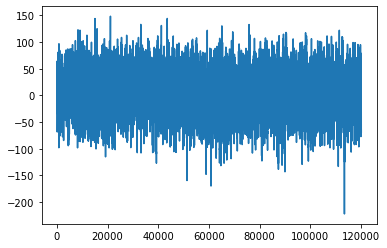

-65.40067291259766
1149891
-65.40067


In [37]:
# Convert all list values to ints
data_between_events = get_data_between_events(raw_ecog_data, np.array(Events['ReachStart']), np.array(Events['ReachStop']))

plt.plot(data_between_events[0,:])
plt.show()

print(data_between_events[0,-1])
print(Events['ReachStop'][139])
print(raw_ecog_data[0,Events['ReachStop'][139]-1])

(211, 26010)
39974.6279296875


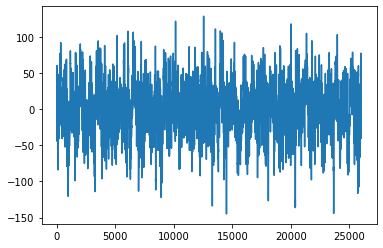

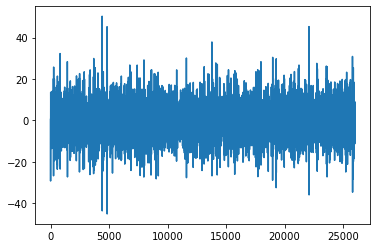

In [9]:
print(preproc_ecog_data.shape)
print(var_thresh)

plt.figure()
plt.plot(raw_ecog_data[0,:])
plt.show()


plt.figure()
plt.plot(preproc_ecog_data[0,:])
plt.show()


In [79]:
import ima_fa
import importlib
importlib.reload(ima_fa)

# Load data
basedir = 'E:/aolab/data/Wireless_ECOG/180325/task/'

# Define parameters
# datapath = 'E:/aolab/data/Wireless_ECOG/180325/spont/rec004.LM1_ECOG_3.clfp.dat'
datafilename = 'rec007.LM1_ECOG_3.clfp.dat'
datapath = os.path.join(basedir, datafilename)
data_in, data_param, data_mask = datareader.load_ecog_clfp_data(datapath)

# FA Parameters
ncomp_fa = np.arange(1, 5 ,1).astype(int)
nfold = 4
maxiter = 10000
log_likelihood_score, iterations_required = ima_fa.ima_fa(data_in[:,:1000].T, ncomp_fa, nfold)

Loading data file:


In [81]:
print(log_likelihood_score.shape)
print(iterations_required.shape)

print(log_likelihood_score)
print(iterations_required)

(4, 4)
(4, 4)
[[-10140.60308457  -4630.78298936  -4769.88851491  -4697.99611093]
 [-11114.96986771  -4731.56198945  -4794.80120667  -4814.40022116]
 [-13269.78231173  -4868.42029758  -4897.59324002  -4911.14705287]
 [-15701.24266554  -5135.97357937  -5000.74402453  -5105.29232797]]
[[ 9.  8. 11.  9.]
 [17. 20. 16. 61.]
 [26. 14. 14. 13.]
 [24. 13. 16. 13.]]


In [57]:
print(fa_out['log_likelihood_score'].shape)
print(fa_out['iterations_required'].shape)

print(fa_out['log_likelihood_score'])
print(fa_out['iterations_required'])

(4, 4)
(4, 4)
[[-10140.60308457  -4630.78298936  -4769.88851491  -4697.99611093]
 [-11114.96986771  -4731.56198945  -4794.80120667  -4814.40022116]
 [-13269.78231173  -4868.42029758  -4897.59324002  -4911.14705287]
 [-15701.24266554  -5135.97357937  -5000.74402453  -5105.29232797]]
[[ 9.  8. 11.  9.]
 [17. 20. 16. 61.]
 [26. 14. 14. 13.]
 [24. 13. 16. 13.]]


Cross validating and fitting ...
20% Complete
40% Complete
60% Complete
80% Complete
100% Complete
[0 1 2 3 4]
(100, 16)
Score  [[-439.78548031 -449.90747772 -542.93095668]
 [-285.52217397 -285.67988556 -281.49605615]
 [-202.90767529 -244.73913937 -205.06113286]
 [-271.72759957 -312.78913052 -245.81146872]
 [-445.35975385 -377.3914981  -340.17778957]]
Iterations  [[ 3.  3.  3.]
 [23. 37. 27.]
 [ 6. 12.  7.]
 [35. 34. 41.]
 [47. 63. 43.]]
[-477.5413049  -284.23270523 -217.56931584 -276.77606627 -387.64301384]
2


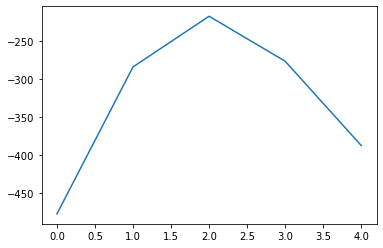

In [229]:
#test_data = np.array([[1,2,3,4], [1,2,3,4], [1,2,3,4], [1,2,3,4], [1,2,3,4], [1,2,3,4]]) + np.random.normal(0, .1, size = (6, 4))
#n = 100
#factor1 = 5# + np.random.normal(0, 1, size = (n))
#factor2 = np.arange(1,n+1, 1)/10# - np.random.normal(0, 1, size = (n))

n = 100
factor1 = 5
factor2 = np.arange(1,n+1, 1)/10

test_data = np.zeros((n, 16))
test_data[:,0] = 2*factor1 + 3*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,1] = 4*factor1 + factor2 + np.random.normal(0, 1, size = (n))
test_data[:,2] = factor1 - factor2 + np.random.normal(0, 1, size = (n))
test_data[:,3] = -2*factor1 + 4*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,4] = 3*(factor1+factor2)+ np.random.normal(0, 1, size = (n))
test_data[:,5] = factor1 - 0.5*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,6] = 2*factor1 + 7*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,7] = 4*factor1 - 3*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,8] = factor1 - 0.5*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,9] = 2.5*factor1 + 9*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,10] = factor1 - .136*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,11] = 7+2*factor1 + 7*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,12] = 1.5*factor1 - 3*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,13] = 2.67*factor1 - 0.5*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,14] = 7*factor1 + 9*factor2 + np.random.normal(0, 1, size = (n))
test_data[:,15] = 2+ factor1 - .136*factor2 + np.random.normal(0, 1, size = (n))


ncomp_fa = np.arange(0,5 ,1).astype(int)
log_likelihood_score, iterations_required = ima_fa.ima_fa(test_data, ncomp_fa, nfold= 3, maxiter = 100, verbose = True)

print(ncomp_fa)
print(test_data.shape)
#print('Test data ', test_data)
print('Score ', log_likelihood_score)
print('Iterations ', iterations_required)
print(np.mean(log_likelihood_score, 1))
print(np.argmax(np.mean(log_likelihood_score, 1)))
plt.plot(np.mean(log_likelihood_score, 1))
plt.show()